# Dog Skin Diseases Classification

The notebook incorporates the model utilized for classifying skin diseases of dogs (3 diseases and 1 healthy class). A customley made datasetspecially for Sri Lanka is used for training, validating and testing the model. The development of the classification model followed a baseline CNN architecture. To assess the performance of the model, several evaluation metrics were employed, including accuracy, F1-score, precision, recall, and evaluation matrix. The output from each metric indicates that the model achieved a high level of accuracy in classifying the eye images.


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, models

In [2]:
# Set dataset path
TRAIN_PATH = r'E:\Year04\IRP\dataset\organized_data_augment\train'
VAL_PATH = r'E:\Year04\IRP\dataset\organized_data_augment\val'
TEST_PATH = r'E:\Year04\IRP\dataset\organized_data_augment\test'

In [3]:
# Load the datasets from directories
train_gen = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    image_size=(128, 128),
    batch_size=32,
    label_mode='categorical'
)

val_gen = tf.keras.utils.image_dataset_from_directory(
    VAL_PATH,
    image_size=(128, 128),
    batch_size=32,
    label_mode='categorical'
)

test_gen = tf.keras.utils.image_dataset_from_directory(
    TEST_PATH,
    image_size=(128, 128),
    batch_size=32,
    label_mode='categorical'
)

Found 8795 files belonging to 4 classes.
Found 2513 files belonging to 4 classes.
Found 1257 files belonging to 4 classes.


In [4]:
# Get class labels
class_labels = train_gen.class_names
print("Class Labels:", class_labels)

Class Labels: ['canine_scabies', 'fungal_infection', 'healthy', 'hypersensitivity_allergies']


### Plot Images with labels

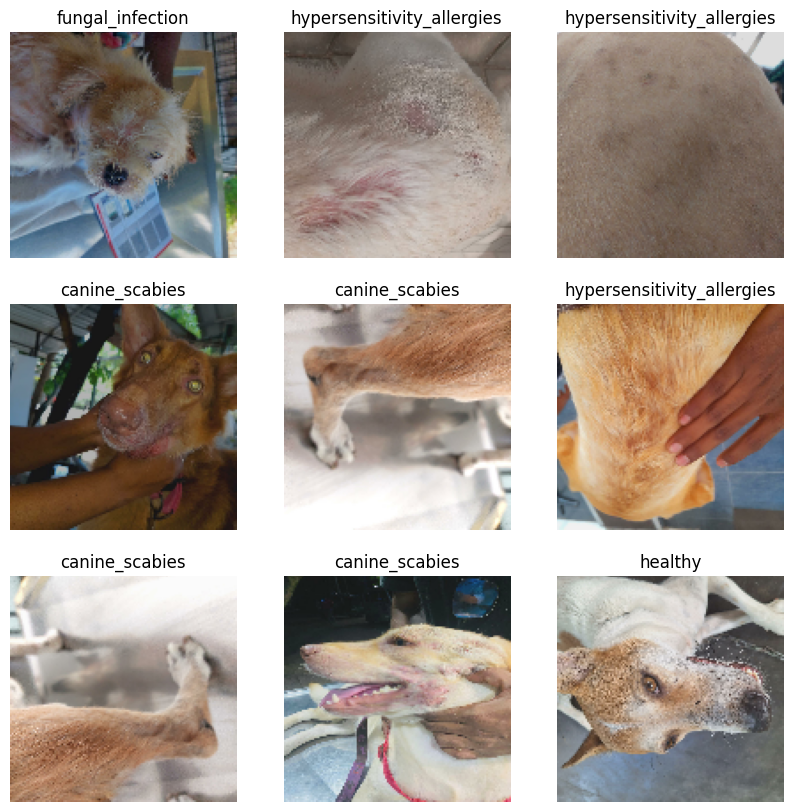

In [4]:

# Function to visualize some images from the dataset
def visualize_images(dataset, class_labels):
    plt.figure(figsize=(10, 10))
    
    for images, labels in dataset.take(1):  # Take one batch from dataset
        images = images.numpy().astype("uint8")  # Convert to NumPy array
        labels = labels.numpy()  # Convert labels to NumPy array
        
        for i in range(9):  # Display 9 images
            plt.subplot(3, 3, i+1)
            plt.imshow(images[i])
            plt.title(class_labels[np.argmax(labels[i])])  # Get class label
            plt.axis("off")
    
    plt.show()

# Call the function
visualize_images(train_gen, train_gen.class_names)

In [ ]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import GlobalAveragePooling2D

def create_cnn_model(input_shape=(128, 128, 3), num_classes=4):
    model = models.Sequential([
        # Convolutional layers with Batch Normalization and L2 regularization
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        # Global Average Pooling instead of Flatten to reduce parameters
        layers.GlobalAveragePooling2D(),
        # Fully connected layers
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),
        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
    return model
model = create_cnn_model(input_shape=(128,128,3), num_classes=4)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       256       
 hNormalization)                                                 
                                                        

In [6]:
# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [7]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('baseline_best.h5', monitor='val_accuracy', save_best_only=True)
lrr = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.2, 
    min_lr=0.0001
)


In [8]:
# Training
history = model.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen,
    callbacks=[early_stop, checkpoint, lrr]
)


Epoch 1/30
275/275 [==============================] - 213s 754ms/step - loss: 2.2824 - accuracy: 0.3897 - precision_1: 0.4645 - recall_1: 0.1264 - val_loss: 1.6985 - val_accuracy: 0.2905 - val_precision_1: 0.4000 - val_recall_1: 0.0016 - lr: 0.0010
Epoch 2/30
275/275 [==============================] - 204s 723ms/step - loss: 1.3678 - accuracy: 0.4403 - precision_1: 0.5645 - recall_1: 0.1617 - val_loss: 1.6066 - val_accuracy: 0.2984 - val_precision_1: 0.2937 - val_recall_1: 0.1811 - lr: 0.0010
Epoch 3/30
275/275 [==============================] - 221s 783ms/step - loss: 1.2875 - accuracy: 0.4810 - precision_1: 0.5938 - recall_1: 0.2327 - val_loss: 1.5396 - val_accuracy: 0.4023 - val_precision_1: 0.4460 - val_recall_1: 0.2793 - lr: 0.0010
Epoch 4/30
275/275 [==============================] - 217s 769ms/step - loss: 1.2421 - accuracy: 0.5188 - precision_1: 0.6283 - recall_1: 0.2912 - val_loss: 1.7917 - val_accuracy: 0.3418 - val_precision_1: 0.3313 - val_recall_1: 0.0641 - lr: 0.0010
Epoc

### Plot Accuracy & Loss graphs

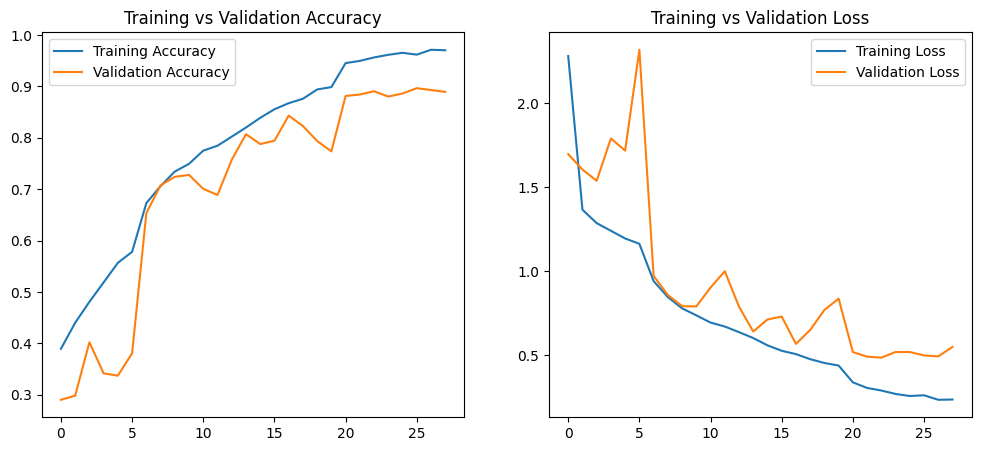

In [9]:
# Evaluation
# Plot Training vs Validation Accuracy and Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'] , label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()

### Train, Validation & Test accuracy from saved model

In [10]:
from keras.models import load_model

# Load the saved model
saved_model = load_model('baseline_best.h5')

# Evaluate on training data
train_results = saved_model.evaluate(train_gen, verbose=0)
print(f"Training - Loss: {train_results[0]:.4f}, Accuracy: {train_results[1]*100:.2f}%, Precision: {train_results[2]*100:.2f}%, Recall: {train_results[3]*100:.2f}%")

# Evaluate on validation data
val_results = saved_model.evaluate(val_gen, verbose=0)
print(f"Validation - Loss: {val_results[0]:.4f}, Accuracy: {val_results[1]*100:.2f}%, Precision: {val_results[2]*100:.2f}%, Recall: {val_results[3]*100:.2f}%")

# Evaluate on test data
test_results = saved_model.evaluate(test_gen, verbose=0)
print(f"Test - Loss: {test_results[0]:.4f}, Accuracy: {test_results[1]*100:.2f}%, Precision: {test_results[2]*100:.2f}%, Recall: {test_results[3]*100:.2f}%")


Training - Loss: 0.2368, Accuracy: 97.16%, Precision: 97.28%, Recall: 96.87%
Validation - Loss: 0.4998, Accuracy: 89.65%, Precision: 90.08%, Recall: 89.22%
Test - Loss: 0.5153, Accuracy: 89.66%, Precision: 90.63%, Recall: 89.26%


### Predictions on Test data

In [17]:
prediction_effnet = saved_model.predict(test_gen) 
prediction_effnet=np.argmax(prediction_effnet,axis=1)

In [18]:
true_labels = []  

for image_batch, label_batch in test_gen:
    true_labels.append(label_batch)
    
correct_labels = tf.concat([item for item in true_labels], axis = 0)
correct_labels = correct_labels.numpy()


In [19]:
print(type(prediction_effnet))
print(type(correct_labels))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### F1- Score, Precision & Recall and confusion matrix


Classification Report:
                            precision    recall  f1-score   support

            canine_scabies       0.27      0.28      0.28       333
          fungal_infection       0.26      0.23      0.24       344
                   healthy       0.25      0.26      0.25       333
hypersensitivity_allergies       0.17      0.19      0.18       247

                  accuracy                           0.24      1257
                 macro avg       0.24      0.24      0.24      1257
              weighted avg       0.24      0.24      0.24      1257



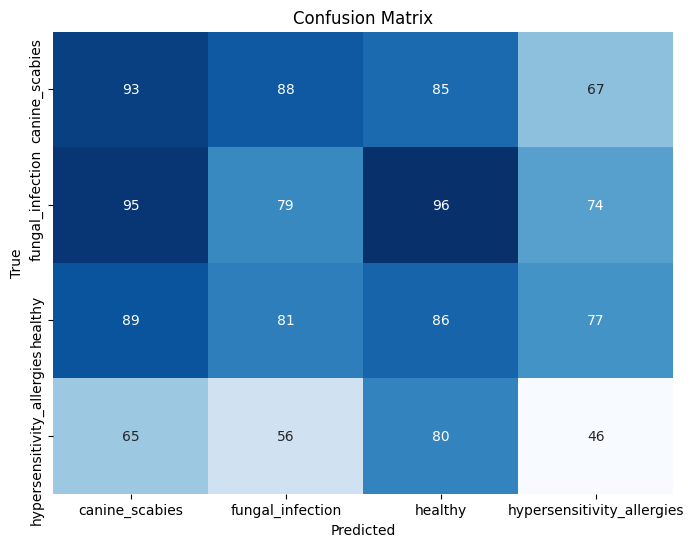

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Convert one-hot encoded labels to class indices if needed
if correct_labels.ndim > 1:
    correct_labels = np.argmax(correct_labels, axis=1)

# Convert predictions to class indices if they are probabilities
if prediction_effnet.ndim > 1:
    prediction_effnet = np.argmax(prediction_effnet, axis=1)

# Ensure both arrays are integers
correct_labels = correct_labels.astype(int)
prediction_effnet = prediction_effnet.astype(int)

# List of class names (Modify with your actual class names)
class_names = ['canine_scabies', 'fungal_infection', 'healthy', 'hypersensitivity_allergies']

# Generate Classification Report
print("Classification Report:")
print(classification_report(correct_labels, prediction_effnet, target_names=class_names))

# Compute Confusion Matrix
conf_matrix = confusion_matrix(correct_labels, prediction_effnet)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Using the model for classification

In [25]:
from keras.models import load_model

load_imagePath = r'E:\Year04\IRP\dataset\dogs\healthy\20240906_104434.jpg'
saved_model = load_model(r'baseline_best.h5')

In [26]:
image_size = (128 ,128)

<class 'numpy.ndarray'>
[[4.2000415e-06 3.2824220e-05 9.9996257e-01 3.0356020e-07]]
Classification:  healthy
Value 0.99996257


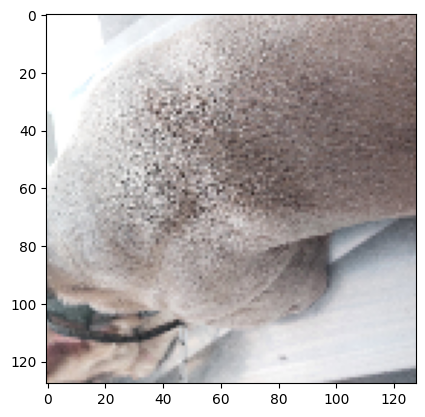

In [27]:
from keras.preprocessing import image

test_img = image.load_img(load_imagePath, target_size = image_size) 
test_image = image.img_to_array(test_img)
test_image = np.expand_dims(test_image, axis = 0)
print(type(test_image))    
result = saved_model.predict(test_image)
print(result)
plt.imshow(test_img) 
print("Classification: ",class_names[int(np.argmax(result,axis=1))])
print("Value", np.amax(result))